In [1]:
#패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import gc
import lightgbm as lgb
import os

In [2]:
#데이터 불러오기
df_train = pd.read_csv('PUBG_train_V2.csv')
df_test = pd.read_csv('PUBG_test_V2.csv')

In [3]:
#메모리 줄이기
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    return df

In [4]:
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

In [5]:
df_train

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.7500,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.0000,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.7500,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.7500,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.7500,2,0,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,0,1292.000000,0,0.000000,0,0,1019.0000,3,1507,0.178589
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,0,0.000000,0,0.000000,0,0,81.6875,6,0,0.293457
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,0,0.000000,0,2.183594,0,0,788.5000,4,0,0.481445
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,2,0.000000,0,0.000000,0,0,2748.0000,8,0,0.799805


In [6]:
df_test

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.468750,0,0,0,73,...,1500,0,0.0,0,0.000000,0,0,588.000,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.125000,0,0,2,11,...,1503,2,4668.0,0,0.000000,0,0,2017.000,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.406250,0,0,4,49,...,1565,0,0.0,0,0.000000,0,0,788.000,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.500000,0,0,0,54,...,1465,0,0.0,0,0.000000,0,0,1812.000,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.250000,1,2,1,7,...,1480,1,0.0,0,0.000000,0,0,2964.000,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934169,a316c3a13887d5,80e82180c90951,f276da5fd73536,1,2,381.000000,3,0,7,4,...,-1,1,0.0,0,0.000000,0,0,1799.000,5,1526
1934170,5312146b27d875,147264a127c56e,fb77cbfe094a6b,0,0,0.000000,0,0,0,64,...,-1,0,0.0,0,0.000000,0,0,1195.000,3,1496
1934171,fc8818b5b32ad3,7bbb4779ebedd5,efb74d5f6e9779,0,0,91.937500,0,0,3,24,...,1482,0,0.0,0,7.796875,1,0,3328.000,3,0
1934172,a0f91e35f8458f,149a506a64c2b1,3a2cf335bc302f,1,2,138.625000,0,0,12,25,...,1456,1,0.0,0,0.000000,0,0,1893.000,4,0


In [7]:
df_test.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

In [8]:
df_train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [9]:
df_train[df_train["winPlacePerc"].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [10]:
df_train=df_train.dropna(inplace=False)

In [11]:
df_train[['Id', 'winPlacePerc']]

,Id,winPlacePerc
0,7f96b2f878858a,0.444336
1,eef90569b9d03c,0.640137
2,1eaf90ac73de72,0.775391
3,4616d365dd2853,0.166748
4,315c96c26c9aac,0.187500
...,...,...
4446961,afff7f652dbc10,0.178589
4446962,f4197cf374e6c0,0.293457
4446963,e1948b1295c88a,0.481445
4446964,cc032cdd73b7ac,0.799805


In [12]:
#훈련용 데이터 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [13]:
#시험용 데이터 
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1934174 entries, 0 to 1934173
Data columns (total 28 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int8   
 4   boosts           int8   
 5   damageDealt      float16
 6   DBNOs            int8   
 7   headshotKills    int8   
 8   heals            int8   
 9   killPlace        int8   
 10  killPoints       int16  
 11  kills            int8   
 12  killStreaks      int8   
 13  longestKill      float16
 14  matchDuration    int16  
 15  matchType        object 
 16  maxPlace         int8   
 17  numGroups        int8   
 18  rankPoints       int16  
 19  revives          int8   
 20  rideDistance     float16
 21  roadKills        int8   
 22  swimDistance     float16
 23  teamKills        int8   
 24  vehicleDestroys  int8   
 25  walkDistance     float16
 26  weaponsAcquired  int16  
 27  winPoints   

In [14]:
print("Train :",df_train.shape)
print("Test :",df_test.shape)

Train : (4446965, 29)
Test : (1934174, 28)


In [15]:
df_train[df_train['rankPoints']== -1][["Id", "winPoints", "rankPoints", "killPoints"]]

,Id,winPoints,rankPoints,killPoints
0,7f96b2f878858a,1466,-1,1241
6,95959be0e21ca3,1497,-1,1262
7,311b84c6ff4390,1500,-1,1000
13,b7807186e3f679,1462,-1,986
14,8e244ac61b6aab,1531,-1,1411
...,...,...,...,...
4446939,36b218fd209b00,1539,-1,1255
4446948,445aaa1ddc858e,1500,-1,1138
4446953,372304ea470cad,1551,-1,1364
4446954,894c01c8e4524f,1502,-1,1007


In [16]:
df_train.describe().drop('count').T

,mean,std,min,25%,50%,75%,max
assists,0.233815,0.588573,0.0,0.000000,0.000000,0.000000,22.0
boosts,1.106908,1.715794,0.0,0.000000,0.000000,2.000000,33.0
damageDealt,NaN,NaN,0.0,0.000000,84.250000,186.000000,6616.0
DBNOs,0.657876,1.145743,0.0,0.000000,0.000000,1.000000,53.0
headshotKills,0.226820,0.602155,0.0,0.000000,0.000000,0.000000,64.0
heals,1.370148,2.679982,0.0,0.000000,0.000000,2.000000,80.0
killPlace,47.599361,27.462931,1.0,24.000000,47.000000,71.000000,101.0
killPoints,505.006156,627.504921,0.0,0.000000,0.000000,1172.000000,2170.0
kills,0.924784,1.558445,0.0,0.000000,0.000000,1.000000,72.0
killStreaks,0.543955,0.710972,0.0,0.000000,0.000000,1.000000,20.0


In [17]:
df_train["numGroups"].value_counts()

27    537607
28    488669
26    416744
29    314665
47    269503
       ...  
54       112
66        85
62        64
57        58
55        56
Name: numGroups, Length: 100, dtype: int64

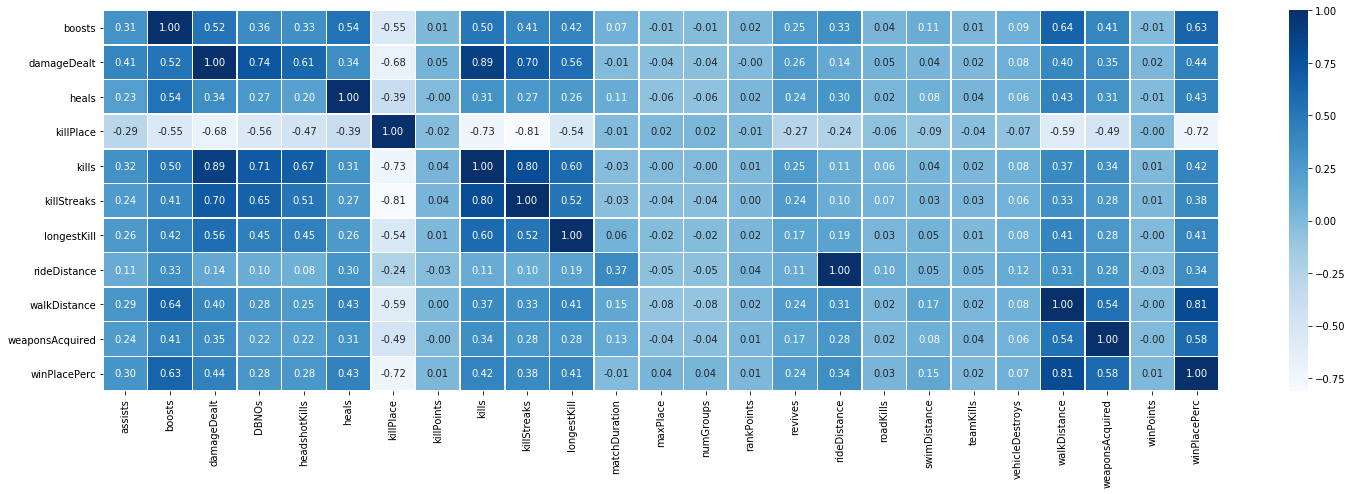

In [18]:
corr = df_train.corr()
high = corr[(corr["winPlacePerc"]>0.3) | (corr["winPlacePerc"]< -0.3)]
plt.figure(figsize = (25, 7))
sns.heatmap(data = high, annot = True, fmt = '.2f', linewidths = .5, cmap = 'Blues')

In [19]:
corr[(corr["winPlacePerc"]>0.3) | (corr["winPlacePerc"]< -0.3)]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
boosts,0.307683,1.000000,0.521947,0.358907,0.334661,0.535854,-0.554844,0.008347,0.502024,0.405327,...,0.253125,0.328855,0.035124,0.107992,0.013068,0.087387,0.640150,0.406609,-0.007645,0.634232
damageDealt,0.406726,0.521947,1.000000,0.735762,0.613409,0.342987,-0.677398,0.049904,0.888784,0.703599,...,0.256951,0.140883,0.052487,0.036729,0.015468,0.081182,0.398199,0.353249,0.017762,0.440506
heals,0.228556,0.535854,0.342987,0.265485,0.199917,1.000000,-0.386032,-0.002585,0.311781,0.270412,...,0.236680,0.297484,0.024619,0.079586,0.035386,0.062870,0.430266,0.309071,-0.010990,0.427856
killPlace,-0.290062,-0.554844,-0.677398,-0.555290,-0.469829,-0.386032,1.000000,-0.023278,-0.730499,-0.810517,...,-0.269804,-0.236202,-0.057356,-0.089396,-0.037797,-0.073569,-0.590236,-0.490144,-0.002415,-0.719069
kills,0.319690,0.502024,0.888784,0.707848,0.674275,0.311781,-0.730499,0.036192,1.000000,0.802500,...,0.253323,0.114749,0.063651,0.039127,0.017601,0.079991,0.374774,0.336414,0.006929,0.419915
killStreaks,0.243471,0.405327,0.703599,0.646872,0.512882,0.270412,-0.810517,0.037091,0.802500,1.000000,...,0.241695,0.098420,0.065575,0.034588,0.027612,0.064374,0.327639,0.275373,0.008552,0.377566
longestKill,0.261426,0.423291,0.563838,0.451422,0.447261,0.263278,-0.541147,0.014084,0.602937,0.515097,...,0.170134,0.190853,0.025214,0.053455,0.007604,0.083227,0.413810,0.276264,-0.003720,0.410153
rideDistance,0.110644,0.328855,0.140883,0.102536,0.076494,0.297484,-0.236202,-0.029316,0.114749,0.098420,...,0.109946,1.000000,0.103518,0.049448,0.050178,0.119254,0.310936,0.282246,-0.027809,0.342914
walkDistance,0.290305,0.640150,0.398199,0.284660,0.250982,0.430266,-0.590236,0.004630,0.374774,0.327639,...,0.236796,0.310936,0.016736,0.167509,0.024858,0.076237,1.000000,0.541222,-0.002043,0.810886
weaponsAcquired,0.243882,0.406609,0.353249,0.218161,0.217552,0.309071,-0.490144,-0.003978,0.336414,0.275373,...,0.167281,0.282246,0.016494,0.075698,0.035918,0.061012,0.541222,1.000000,-0.003815,0.583806


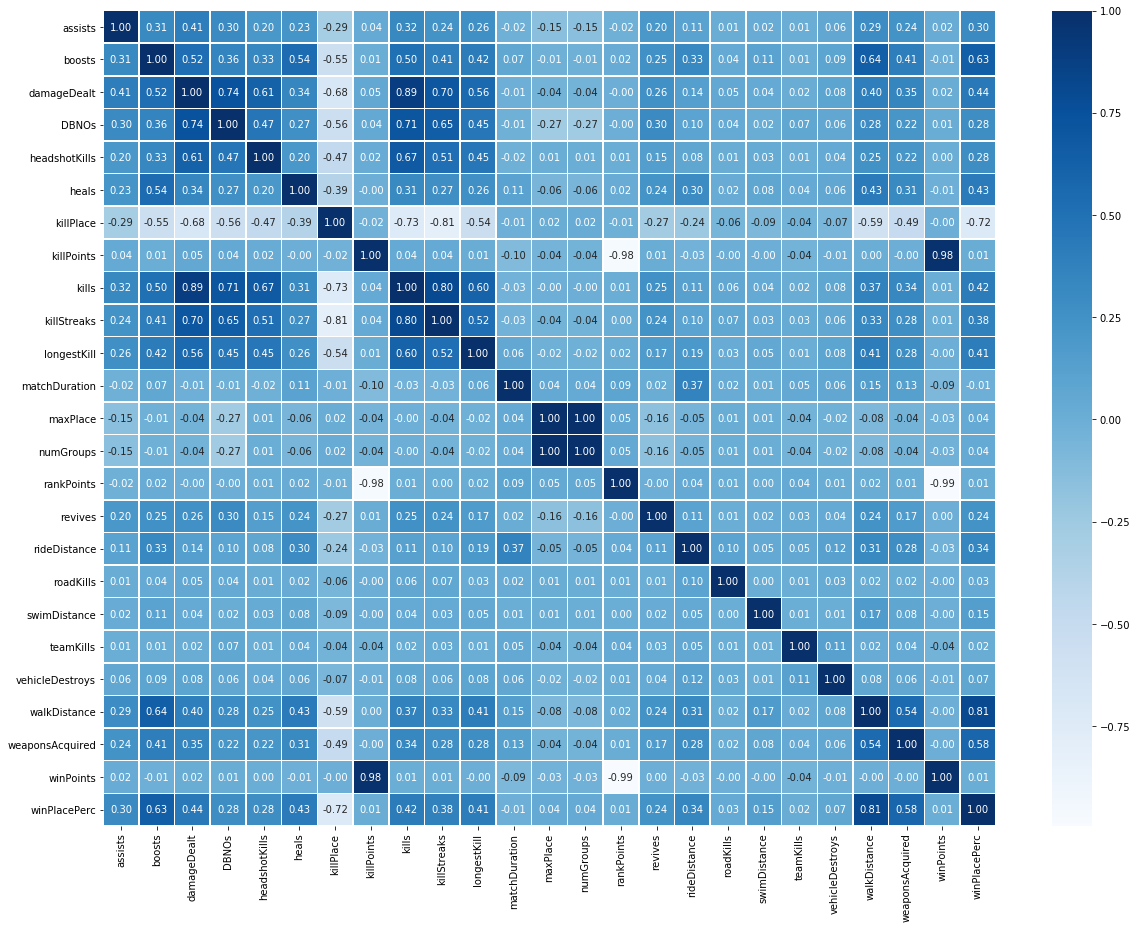

In [20]:
plt.figure(figsize = (20, 15))
sns.heatmap(data = corr, annot = True, fmt = '.2f', linewidths = .5, cmap = 'Blues')

In [21]:
df_train.loc[df_train.maxPlace > 0, "winPlacePerc"]

0          0.444336
1          0.640137
2          0.775391
3          0.166748
4          0.187500
             ...   
4446961    0.178589
4446962    0.293457
4446963    0.481445
4446964    0.799805
4446965    0.546387
Name: winPlacePerc, Length: 4446965, dtype: float16

In [22]:
#피처 조합
df_train['totalDistance'] = df_train['rideDistance'] + df_train["walkDistance"] + df_train["swimDistance"]
df_train['healitem'] = df_train['heals'] + df_train['boosts']
df_train['killPlace_over_maxPlace'] = df_train['killPlace'] / df_train['maxPlace']
df_train["onekill"] = df_train["headshotKills"] + df_train["roadKills"]
df_train['kills_assists'] = df_train['kills'] + df_train['assists']

df_train["ELO"] = df_train["killPoints"] + df_train["rankPoints"] + df_train["winPoints"]
df_train["item"] = df_train["boosts"] + df_train["weaponsAcquired"]

df_train.loc[df_train.maxPlace == 0, "winPlacePerc"] = 0
df_train.loc[df_train.maxPlace == 1, "winPlacePerc"] = 1

df_train.loc[(df_train.maxPlace > 1) & (df_train.numGroups == 1), "winPlacePerc"] = 0

df_train.loc[df_train.winPlacePerc < 0, "winPlacePerc"] = 0
df_train.loc[df_train.winPlacePerc > 1, "winPlacePerc"] = 1

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

# fpp(first person perspective / 1인칭) :
- rank : squad-fpp / duo-fpp / solo-fpp
- normal : normal-squad-fpp / normal-duo-fpp / normal-solo-fpp 
- event mode : crashfpp / flarefpp


# tpp(third person perspective / 3인칭) :

- rank : squad / duo / solo
- normal : normal-squad / normal-duo / normal-solo
- event mode : flaretpp / crashtpp

In [23]:
#matchtype 숫자형 변환
#solo - 1 / duo - 2 / squad - 4
mapper = lambda x: 'solo' if ('solo' in x) else 'duo' if ('duo' in x) or ('crash' in x) else 'squad'
df_train['matchType'] = df_train['matchType'].apply(mapper)
mapper = lambda x: 1 if ('solo' in x) else 2 if ('duo' in x) or ('crash' in x) else 4
df_train["matchType"] = df_train['matchType'].apply(mapper)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
df_train = reduce_mem_usage(df_train)
df_train

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,weaponsAcquired,winPoints,winPlacePerc,totalDistance,healitem,killPlace_over_maxPlace,onekill,kills_assists,ELO,item
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,1,1466,0.444336,244.7500,0,2.142578,0,0,2706,1
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,5,0,0.640137,1445.0000,0,2.191406,0,0,1484,5
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,2,0,0.775391,161.7500,0,0.939941,0,1,1491,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,3,0,0.166748,202.7500,0,2.419922,0,0,1408,3
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,2,0,0.187500,49.7500,0,0.463867,0,1,1560,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,3,1507,0.178589,2312.0000,0,2.550781,0,0,2535,3
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,6,0,0.293457,81.6875,1,0.741699,0,0,1501,7
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,4,0,0.481445,790.5000,0,2.357422,0,0,1500,4
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,8,0,0.799805,2748.0000,6,0.423096,1,2,1418,12


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446965 entries, 0 to 4446965
Data columns (total 36 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Id                       object 
 1   groupId                  object 
 2   matchId                  object 
 3   assists                  int8   
 4   boosts                   int8   
 5   damageDealt              float16
 6   DBNOs                    int8   
 7   headshotKills            int8   
 8   heals                    int8   
 9   killPlace                int8   
 10  killPoints               int16  
 11  kills                    int8   
 12  killStreaks              int8   
 13  longestKill              float16
 14  matchDuration            int16  
 15  matchType                int8   
 16  maxPlace                 int8   
 17  numGroups                int8   
 18  rankPoints               int16  
 19  revives                  int8   
 20  rideDistance             float16
 21  roadKill

In [26]:
#Y
df_target=df_train['winPlacePerc']
del df_train['winPlacePerc']

#문자형이라 제거
del df_train['Id']
del df_train['groupId']
del df_train['matchId']

In [27]:
df_target = df_target.to_frame()
df_target

,winPlacePerc
0,0.444336
1,0.640137
2,0.775391
3,0.166748
4,0.187500
...,...
4446961,0.178589
4446962,0.293457
4446963,0.481445
4446964,0.799805


In [28]:
print("X 데이터 형태 :", df_train.shape)
print("Y 데이터 형태 :", df_target.shape)

X 데이터 형태 : (4446965, 32)
Y 데이터 형태 : (4446965, 1)


In [29]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(df_train, df_target, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=42)

In [30]:
print("X_train 형태 :", X_train.shape)
print("X_test 형태 :", X_test.shape)
print("Y_train 형태 :", y_train.shape)
print("Y_test 형태 :", y_test.shape)

X_train 형태 : (2846057, 32)
X_test 형태 : (889393, 32)
Y_train 형태 : (2846057, 1)
Y_test 형태 : (889393, 1)


In [31]:
from sklearn.linear_model import RidgeCV
ridge_cv = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 
                             1, 3, 6, 10, 15, 25, 30, 35, 40, 45, 50, 
                             55, 60, 75, 100, 200, 500, 1000])
ridge_cv.fit(X_train, y_train)
alpha = ridge_cv.alpha_
print("Best alpha :", alpha)

Best alpha : 100.0


In [32]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
print("학습용 데이터 세트 점수: {:.2f}".format(ridge.score(X_train, y_train)))
print("평가용 데이터 세트 점수: {:.2f}".format(ridge.score(X_test, y_test)))

학습용 데이터 세트 점수: 0.83
평가용 데이터 세트 점수: 0.83


In [33]:
from sklearn.metrics import mean_squared_error
predicted = ridge.predict(X_train)
mean_squared_error(y_train, predicted)

0.01592256

In [34]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)
print("학습용 데이터 세트 점수: {:.2f}".format(lasso.score(X_train, y_train)))
print("평가용 데이터 세트 점수: {:.2f}".format(lasso.score(X_test, y_test)))
print("사용한 피처의 개수: ", np.sum(lasso.coef_ !=0))

학습용 데이터 세트 점수: 0.74
평가용 데이터 세트 점수: 0.74
사용한 피처의 개수:  7


In [35]:
from sklearn.metrics import mean_squared_error
predicted = lasso.predict(X_train)
mean_squared_error(y_train, predicted)

0.024150833

In [36]:
df_int_train=df_train.astype('int')
df_int_target=df_target.astype('int')

In [37]:
df_int_train = reduce_mem_usage(df_int_train)

In [38]:
print(df_int_train.dtypes)

assists                     int8
boosts                      int8
damageDealt                int16
DBNOs                       int8
headshotKills               int8
heals                       int8
killPlace                   int8
killPoints                 int16
kills                       int8
killStreaks                 int8
longestKill                int16
matchDuration              int16
matchType                   int8
maxPlace                    int8
numGroups                   int8
rankPoints                 int16
revives                     int8
rideDistance               int32
roadKills                   int8
swimDistance               int16
teamKills                   int8
vehicleDestroys             int8
walkDistance               int16
weaponsAcquired            int16
winPoints                  int16
totalDistance              int32
healitem                    int8
killPlace_over_maxPlace     int8
onekill                     int8
kills_assists               int8
ELO       

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_int_train, df_int_target, random_state=0)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbrt = GradientBoostingClassifier(random_state = 0)
gbrt.fit(X_train, y_train)
print("학습용 세트 점수: {:.3f}".format(gbrt.score(X_train, y_train)))
print("평가용 세트 점수: {:.3f}".format(gbrt.score(X_test, y_test)))

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
